In [26]:
import kagglehub
import os
import glob
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet


In [2]:
# Download latest version
path = kagglehub.dataset_download("joserzapata/free-spoken-digit-dataset-fsdd")

print("Path to dataset files:", path)

100%|██████████| 15.5M/15.5M [00:00<00:00, 62.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/joserzapata/free-spoken-digit-dataset-fsdd/versions/1


In [27]:
# Define the dataset path using the downloaded path
data_path = path + "/recordings"

# List all WAV files in the recordings folder
file_paths = glob.glob(os.path.join(data_path, "*.wav"))

# Prepare lists for train and test files and their corresponding labels
train_files = []
train_labels = []
test_files = []
test_labels = []

# The file naming convention is: {digitLabel}_{speakerName}_{index}.wav
# Test set: recordings with index 0-4; Train set: recordings with index 5-49.
for fp in file_paths:
    filename = os.path.basename(fp)  # e.g., "7_jackson_32.wav"
    parts = filename.split('_')
    if len(parts) < 3:
        continue  # Skip if the filename doesn't match the expected format
    label = parts[0]  # The digit label is the first part
    # Extract the index from the third part (remove the .wav extension)
    index_str = parts[2].split('.')[0]
    index = int(index_str)

    if index <= 4:
        test_files.append(fp)
        test_labels.append(label)
    else:
        train_files.append(fp)
        train_labels.append(label)

print("Number of training files:", len(train_files))
print("Number of test files:", len(test_files))

#load the audio files using librosa (keeping the sample rate at 8kHz)
def load_audio_files(file_list, sr=8000):
    data = []
    for fp in file_list:
        audio, _ = librosa.load(fp, sr=sr)
        data.append(audio)
    return data

train_data = load_audio_files(train_files)
test_data = load_audio_files(test_files)

# At this point:
# - train_data and test_data are lists of audio signals.
# - train_labels and test_labels are lists of string labels.
print("Loaded", len(train_data), "training audio files and", len(test_data), "test audio files.")


Number of training files: 2700
Number of test files: 300
Loaded 2700 training audio files and 300 test audio files.


In [28]:
def compute_spectrogram(audio, sr=8000, n_fft=2048, hop_length=512):
    """
    Compute the log-scaled spectrogram of an audio signal.

    Parameters:
      audio: numpy array of the audio signal.
      sr: sampling rate.
      n_fft: number of FFT components.
      hop_length: number of samples between successive frames.

    Returns:
      log_spectrogram: log-scaled (in dB) spectrogram.
    """
    # Compute the short-time Fourier transform (STFT)
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    # Get the magnitude of the STFT
    spectrogram = np.abs(stft)
    # Convert amplitude to decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return log_spectrogram


def plot_spectrogram(spec, sr=8000, hop_length=512):
    """
    Plot the log-scaled spectrogram.

    Parameters:
      spec: numpy array of the log-scaled spectrogram.
      sr: sampling rate.
      hop_length: number of samples between successive frames.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Scaled Spectrogram')
    plt.tight_layout()
    plt.show()


Unique training classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Digit: 0


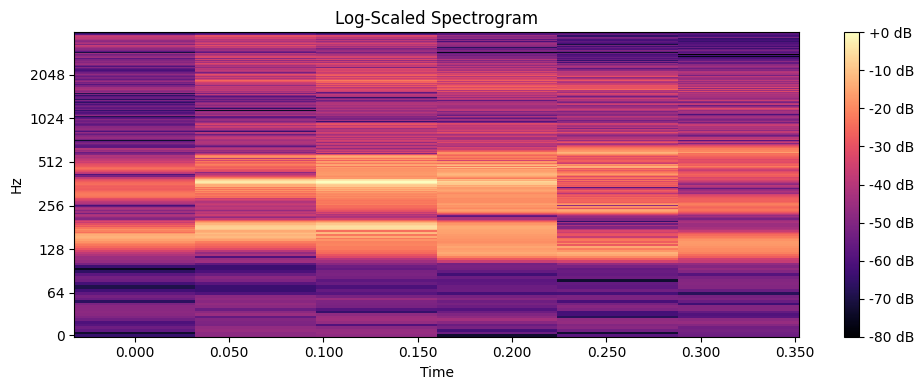

Digit: 1


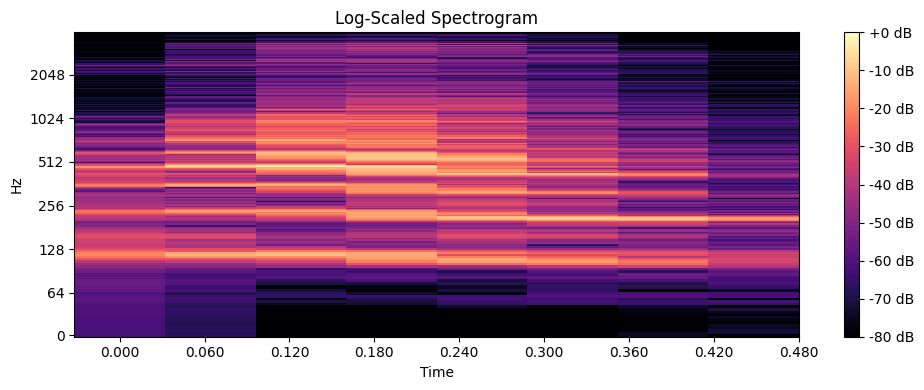

Digit: 2


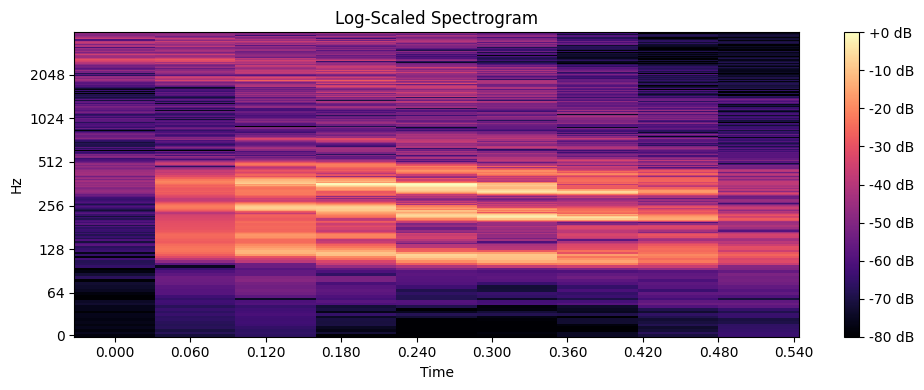

Digit: 3


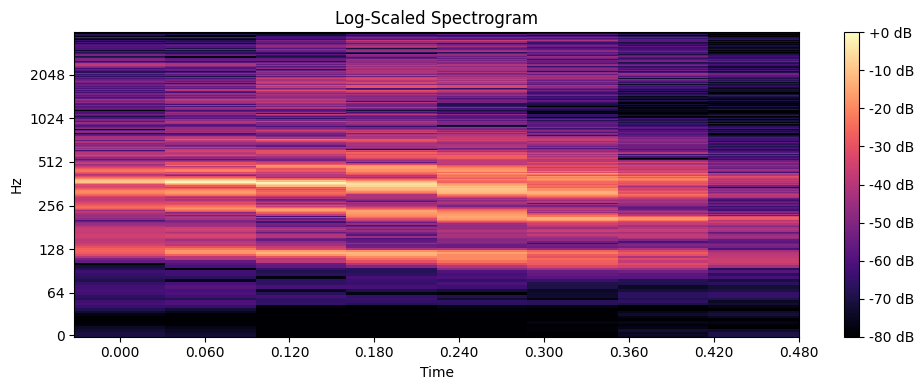

Digit: 4


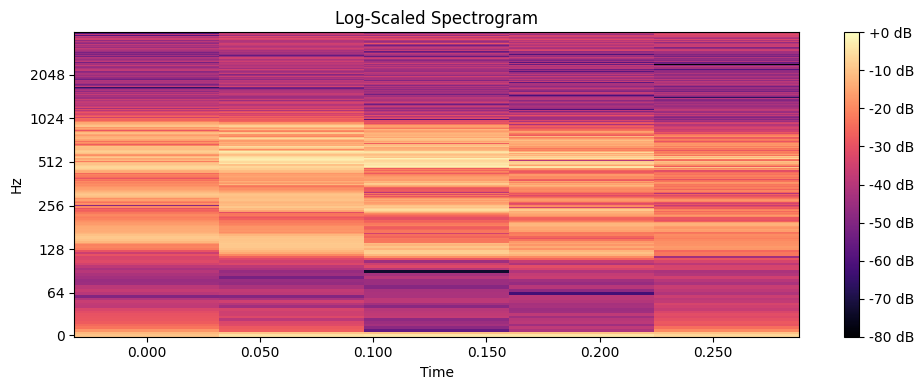

Digit: 5


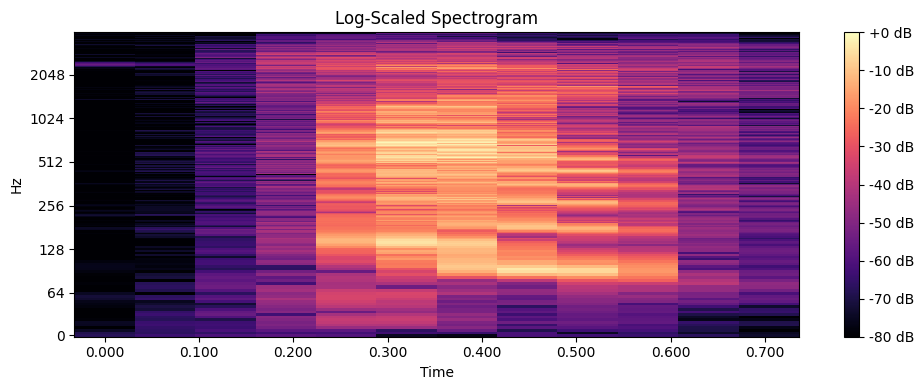

Digit: 6


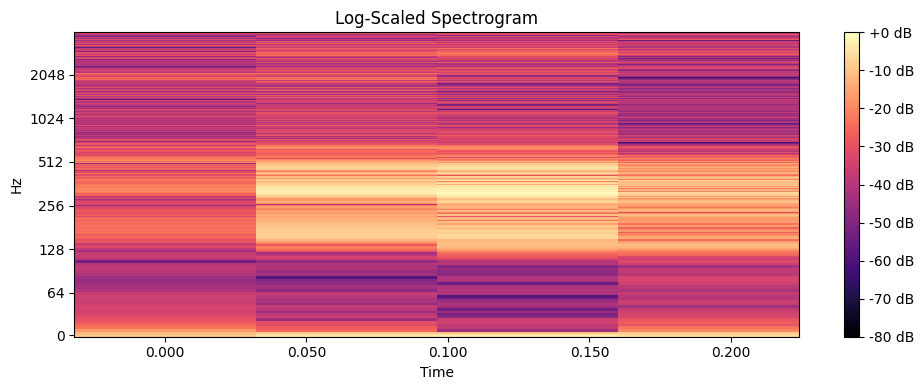

Digit: 7


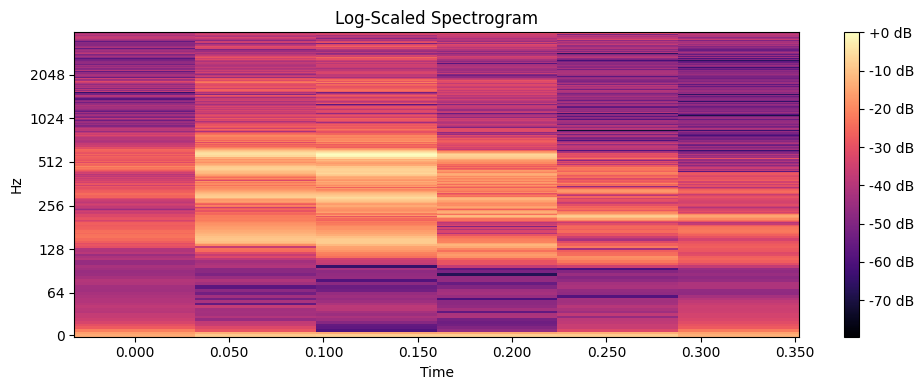

Digit: 8


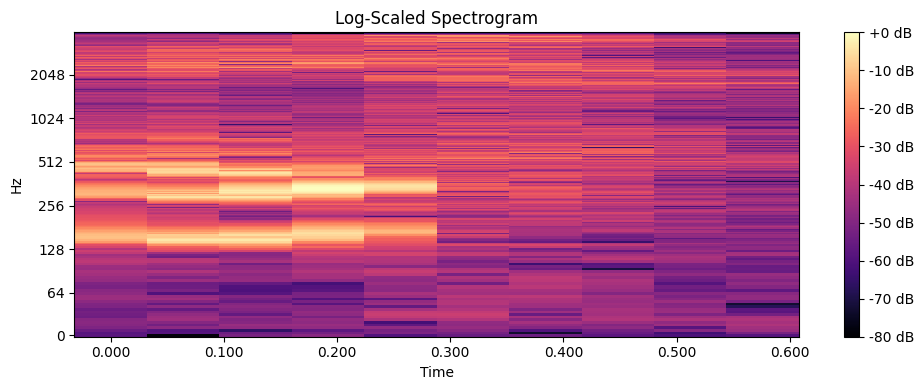

Digit: 9


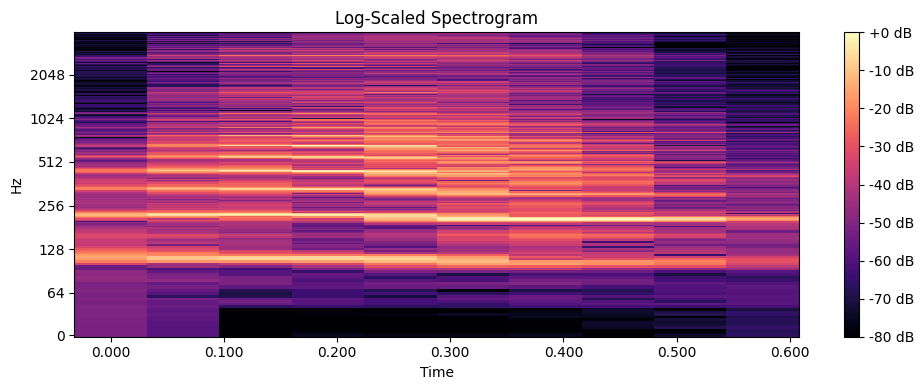

In [29]:
# Convert the whole training set to spectrograms
train_spectrograms = []
for audio in train_data:
    spec = compute_spectrogram(audio, sr=8000, n_fft=2048, hop_length=512)
    train_spectrograms.append(spec)

# Convert the whole test set to spectrograms
test_spectrograms = []
for audio in test_data:
    spec = compute_spectrogram(audio, sr=8000, n_fft=2048, hop_length=512)
    test_spectrograms.append(spec)

# Display a sample spectrogram from each unique class in the training set
# Assuming train_labels are strings representing the digit (e.g., "0", "1", ..., "9")
unique_classes = sorted(set(train_labels), key=lambda x: int(x))
print("Unique training classes:", unique_classes)

for digit in unique_classes:
    # Find the index of the first occurrence of this digit in the training labels
    idx = train_labels.index(digit)
    spec = train_spectrograms[idx]
    print("Digit:", digit)
    plot_spectrogram(spec)


In [30]:
# Custom Dataset for precomputed spectrograms with resizing
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, output_size=(224, 224), transform=None):
        """
        spectrograms: list/array of 2D numpy arrays representing spectrograms.
        labels: list/array of corresponding labels.
        output_size: desired output size (H, W) for the spectrogram image.
        transform: any additional transforms.
        """
        self.spectrograms = spectrograms
        self.labels = labels
        self.output_size = output_size
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        # Convert spectrogram (2D array) to a torch tensor and add channel dimension
        image = torch.tensor(self.spectrograms[idx], dtype=torch.float32).unsqueeze(0)  # shape: [1, H, W]

        # Resize the spectrogram to the desired size using bilinear interpolation.
        # Add a batch dimension first.
        image = image.unsqueeze(0)  # shape: [1, 1, H, W]
        image = torch.nn.functional.interpolate(image, size=self.output_size, mode='bilinear', align_corners=False)
        image = image.squeeze(0)  # shape: [1, output_size[0], output_size[1]]

        # Optionally apply additional transforms
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [31]:
def pad_collate_fn(batch):
    """
    Custom collate function that pads each spectrogram in the batch along the width dimension.

    batch: list of tuples (spectrogram, label)
    """
    images, labels = zip(*batch)
    # Find the maximum width among all spectrograms in the batch
    max_width = max(img.size(2) for img in images)
    padded_images = []
    for img in images:
        pad_width = max_width - img.size(2)
        # Pad on the right side of the width dimension; pad format is (left, right)
        padded_img = torch.nn.functional.pad(img, (0, pad_width), mode='constant', value=0)
        padded_images.append(padded_img)
    # Stack the padded images into a single tensor
    images_tensor = torch.stack(padded_images)
    # Convert labels (which are strings) to integers
    labels_tensor = torch.tensor([int(label) for label in labels], dtype=torch.long)
    return images_tensor, labels_tensor


In [38]:
# Define transforms if needed (normalization, etc.)
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the datasets with resizing to 224x224
train_dataset = SpectrogramDataset(train_spectrograms, train_labels, output_size=(224, 224), transform=transform)
test_dataset  = SpectrogramDataset(test_spectrograms, test_labels, output_size=(224, 224), transform=transform)

# Use the same pad_collate_fn to handle any width differences (although now they should all be 224x224)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)

#print the size of the loaded images
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break


Batch of images shape: torch.Size([32, 1, 224, 224])
Batch of labels shape: torch.Size([32])


In [39]:
# Load a pre-trained EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept 1 channel instead of 3
# EfficientNet's first layer is named '_conv_stem'
model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the classifier to output the desired number of classes
num_classes = 10  # Set this to the number of classes in your dataset
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 99.5MB/s]


Loaded pretrained weights for efficientnet-b0


In [40]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model._fc.parameters():
    param.requires_grad = True


In [41]:
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model._fc.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy for the batch
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Acc: {epoch_acc:.2f}%")


Epoch 1/10, Loss: 2.1168, Training Acc: 27.85%
Epoch 2/10, Loss: 1.7948, Training Acc: 45.19%
Epoch 3/10, Loss: 1.6157, Training Acc: 51.07%
Epoch 4/10, Loss: 1.4851, Training Acc: 55.00%
Epoch 5/10, Loss: 1.4155, Training Acc: 56.30%
Epoch 6/10, Loss: 1.3472, Training Acc: 59.22%
Epoch 7/10, Loss: 1.2832, Training Acc: 60.67%


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
import torch
from google.colab import files

# Save only the state dict (recommended)
torch.save(model.state_dict(), 'efficientnet_model.pth')

# Alternatively, to save the entire model:
# torch.save(model, 'efficientnet_model_full.pth')

# Download the saved model file
files.download('efficientnet_model.pth')


In [25]:
!pip install efficientnet-pytorch torchvision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16478 sha256=56d975781ede02352ac0f1e360fcc606658d12e0d1a60aee29de7cf0e6f3878f
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet-pytorch
